# Prediction of Mental Health Treatment Patterns

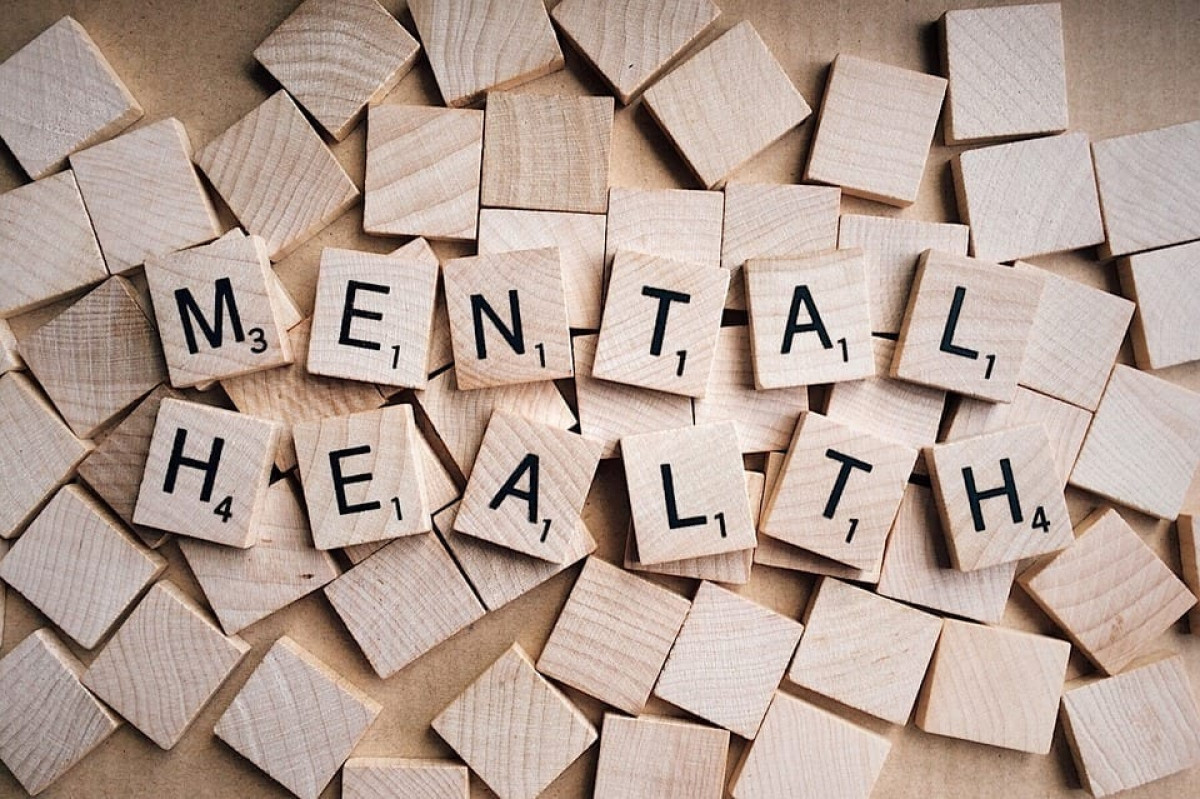

This project aims to analyze and predict patterns of mental health treatment using survey data collected from diverse populations. The workflow involves thorough data cleaning and preprocessing, exploratory analysis to uncover demographic and behavioral trends, and application of various feature selection techniques to identify the most influential factors. Machine learning models are then built and evaluated to accurately predict whether individuals seek mental health treatment. The insights gained from this study can support healthcare providers and policymakers in better understanding treatment behaviors and improving mental health services.

# 1. Setup and Data Loading

In [1]:
!pip install -q category_encoders
!pip install -q skrebate
!pip install -q boruta
!pip install -q matplotlib seaborn scikit-learn pandas numpy


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc



  Preparing metadata (setup.py) ... done


In [2]:
data = pd.read_csv("/kaggle/input/mental-health-in-tech-survey/survey.csv")

print(data.columns)
print(data.head())


Index(['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed',
       'family_history', 'treatment', 'work_interfere', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'comments'],
      dtype='object')
             Timestamp  Age  Gender         Country state self_employed  \
0  2014-08-27 11:29:31   37  Female   United States    IL           NaN   
1  2014-08-27 11:29:37   44       M   United States    IN           NaN   
2  2014-08-27 11:29:44   32    Male          Canada   NaN           NaN   
3  2014-08-27 11:29:46   31    Male  United Kingdom   NaN           NaN   
4  2014-08-27 11:30:22   31    Male   United States    TX           NaN   

  family_history treatment work_interfere  

# 2. Data Cleaning and Preprocessing

In this phase, the raw dataset is cleaned and prepared for analysis. This includes standardizing column names, correcting inconsistent gender entries, and removing unrealistic age values to ensure data quality. Outliers in age are detected and visualized to understand their impact. Finally, categorical variables are encoded into numerical formats to make the data compatible with machine learning algorithms.



## Data Cleaning + Column Formatting

In [3]:
data.columns = data.columns.str.strip().str.lower().str.replace(" ", "_")


## Gender Standardization + Age Outlier Removal

Gender data is cleaned by unifying different entries into consistent categories. Unrealistic age values are detected and removed as outliers to ensure accurate analysis.

In [4]:
data["gender"] = data["gender"].str.lower()
data["gender"] = data["gender"].replace({
    "male-ish": "male", "maile": "male", "mal": "male", "cis male": "male", "man": "male", "msle": "male",
    "female": "female", "femail": "female", "cis female": "female", "woman": "female"
})
data["gender"] = data["gender"].apply(lambda x: "male" if "male" in x else "female" if "female" in x else "other")
data = data[(data["age"] >= 18) & (data["age"] <= 65)]


## Detect Outliers in Age & Histogram

Outliers in the age data are identified using statistical methods, and their distribution is visualized with a histogram to better understand the age range and anomalies.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


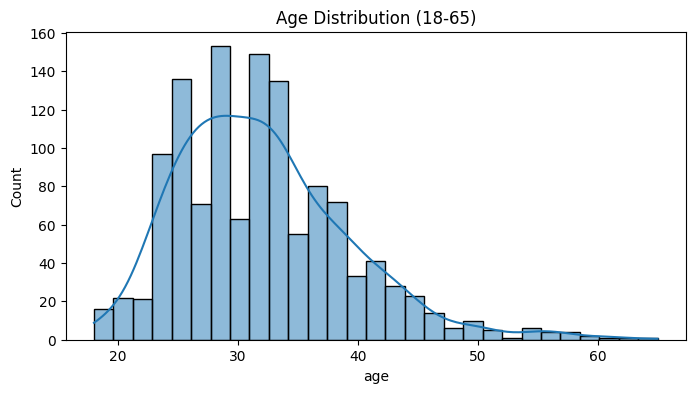

In [5]:
import numpy as np

data["age"] = data["age"].replace([np.inf, -np.inf], np.nan)
data = data.dropna(subset=["age"]) 


plt.figure(figsize=(8, 4))
sns.histplot(data["age"], kde=True)
plt.title("Age Distribution (18-65)")
plt.show()


## Encode the Dataset

Categorical variables are transformed into numerical values using encoding techniques, enabling machine learning models to process the data effectively.

In [6]:
categorical_cols = data.select_dtypes(include="object").columns
le = LabelEncoder()
data_encoding = data.copy()
for col in categorical_cols:
    data_encoding[col] = le.fit_transform(data_encoding[col].astype(str))


# 3. Exploratory Data Analysis (EDA)

Exploratory Data Analysis helps to understand the structure and patterns within the dataset before building models. In this project, EDA is performed to explore how different factors relate to mental health treatment.

Top Countries and States visualizations show where most responses come from.

Pie charts display the proportion of people who have or haven't received treatment.

Pie charts by country and state help understand regional treatment patterns.

A violin plot shows the relationship between age, gender, and treatment status.

A Spearman correlation heatmap is used to identify relationships between numerical features.

Top 10 features most correlated with treatment are highlighted for further analysis.

These insights help identify which variables may be useful for prediction and guide the feature selection and modeling process.

## Top Countries Visualization

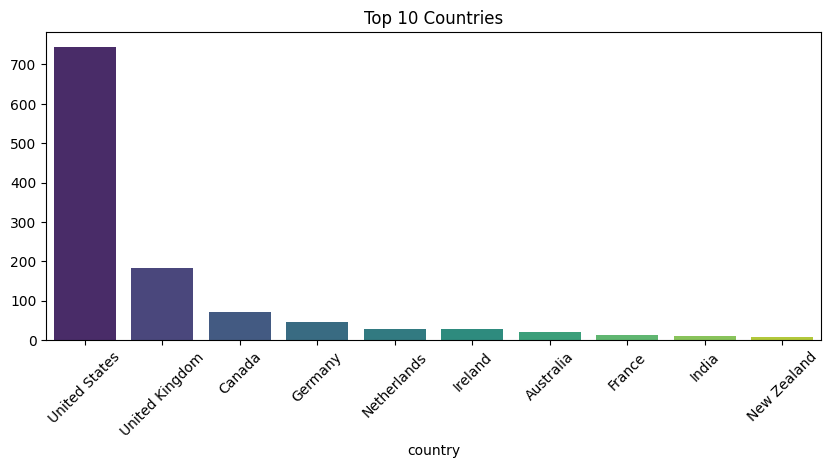

In [7]:
top_countries = data["country"].value_counts().nlargest(10)
plt.figure(figsize=(10, 4))
sns.barplot(x=top_countries.index, y=top_countries.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Countries")
plt.show()


## Top States Visualization

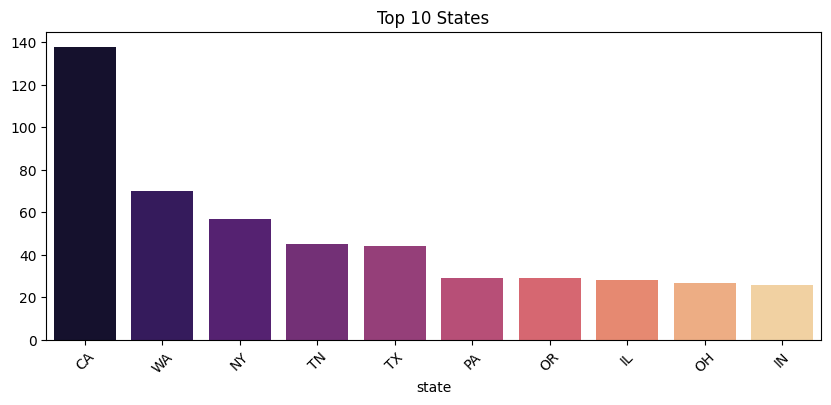

In [8]:
top_states = data["state"].value_counts().nlargest(10)
plt.figure(figsize=(10, 4))
sns.barplot(x=top_states.index, y=top_states.values, palette="magma")
plt.xticks(rotation=45)
plt.title("Top 10 States")
plt.show()
 

## Pie Charts for Country and Treatment

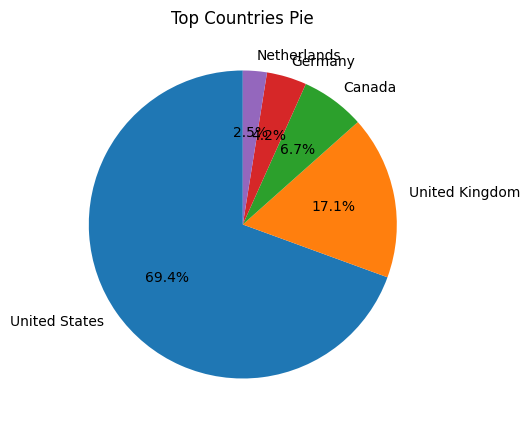

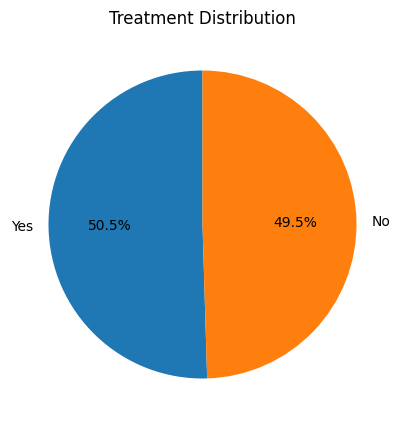

In [9]:
plt.figure(figsize=(5, 5))
data["country"].value_counts().nlargest(5).plot.pie(autopct="%1.1f%%", startangle=90)
plt.title("Top Countries Pie")
plt.ylabel("")
plt.show()

plt.figure(figsize=(5, 5))
data["treatment"].value_counts().plot.pie(autopct="%1.1f%%", startangle=90)
plt.title("Treatment Distribution")
plt.ylabel("")
plt.show()


## Pie Charts for State and Treatment

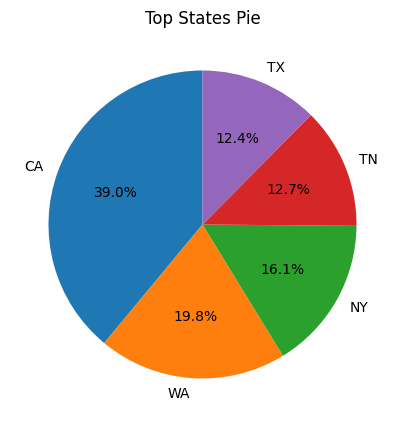

In [10]:
plt.figure(figsize=(5, 5))
data["state"].value_counts().nlargest(5).plot.pie(autopct="%1.1f%%", startangle=90)
plt.title("Top States Pie")
plt.ylabel("")
plt.show()
  

## Violin Plot of Age vs Treatment colored by Gender

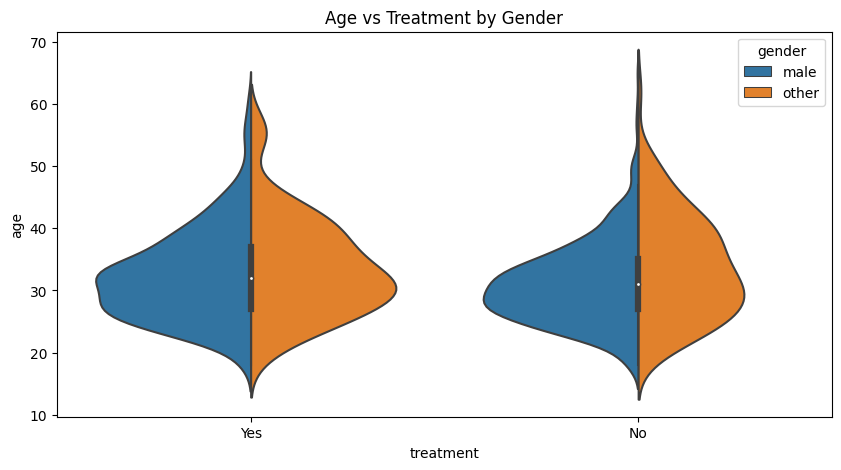

In [11]:
plt.figure(figsize=(10, 5))
sns.violinplot(x="treatment", y="age", hue="gender", data=data, split=True)
plt.title("Age vs Treatment by Gender")
plt.show()


## Correlation Heatmap (Spearman)

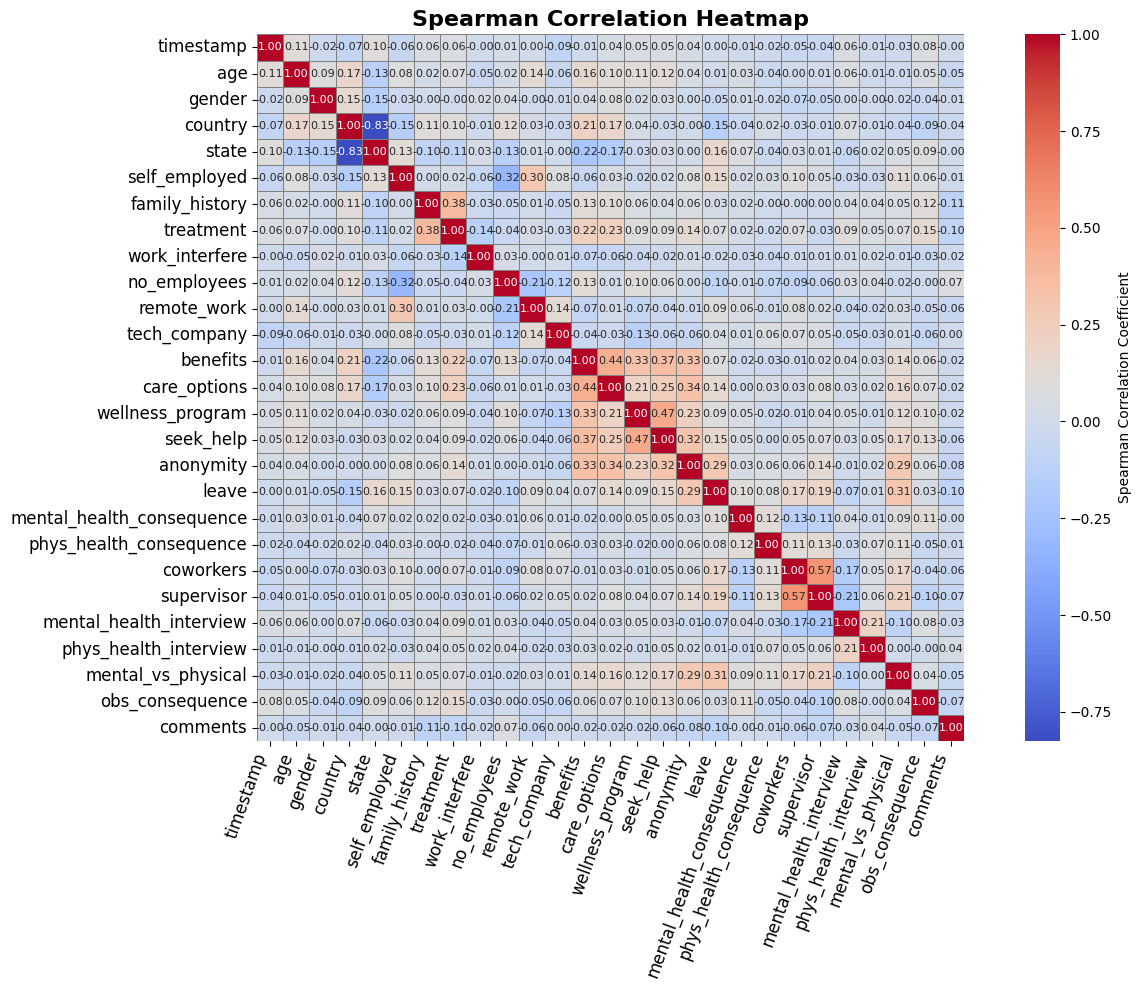

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = data_encoding.corr(method="spearman")

plt.figure(figsize=(14, 10))  
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={"label": "Spearman Correlation Coefficient"},
    square=True,
    linewidths=0.5,
    linecolor='gray',
    annot_kws={"size":8} 
)

plt.title("Spearman Correlation Heatmap", fontsize=16, weight='bold')
plt.xticks(rotation=70, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


##    Top 10 Features Correlated with Treatment

To identify which variables are most related to mental health treatment, a correlation-based analysis was performed. The following features were found to have the strongest relationships with the treatment variable:

family_history, care_options, benefits, obs_consequence, anonymity, work_interfere, state, country, comments, mental_health_interview

These features are likely to influence a person's decision to seek mental health treatment and are important candidates for model training.

In [13]:
cor = data_encoding.corr(method="spearman")["treatment"].abs().sort_values(ascending=False)
top_features = cor[1:11].index.tolist()
print("Top correlated features with treatment:\n", top_features)


Top correlated features with treatment:
 ['family_history', 'care_options', 'benefits', 'obs_consequence', 'anonymity', 'work_interfere', 'state', 'country', 'comments', 'mental_health_interview']


# 4. Feature Selection Techniques

Feature selection is used to identify the most relevant variables that contribute to the prediction of mental health treatment. Several techniques were applied in this project, including:

Chi-Square Test: Selected features based on statistical dependence with the target variable.

Recursive Feature Elimination (RFE): Used logistic regression to recursively remove less important features.

SMLR (Sparse Multinomial Logistic Regression): Extracted key features from a sparse logistic model.

Relief Algorithm: Evaluated feature importance based on their ability to distinguish between nearby instances.

The results from these techniques were combined to finalize the most influential features for model building.

##    Feature Selection

In [14]:
X = data_encoding[top_features]
y = data_encoding["treatment"]


## Feature Selection with Chi-Square and MinMaxScaler

Features are first scaled between 0 and 1 using MinMaxScaler to prepare for the Chi-Square test. Then, the Chi-Square formula

\[
\chi^2 = \sum \frac{(O - E)^2}{E}
\]

 
is used to measure how strongly each feature relates to the target. Features with higher scores are selected for the model.

In [15]:
from sklearn.feature_selection import SelectKBest, chi2
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
chi2_selector = SelectKBest(chi2, k=10)
X_kbest = chi2_selector.fit_transform(X_scaled, y)
selected_chi2 = chi2_selector.get_support(indices=True)
print("Chi-Square selected:", X.columns[selected_chi2].tolist())


Chi-Square selected: ['family_history', 'care_options', 'benefits', 'obs_consequence', 'anonymity', 'work_interfere', 'state', 'country', 'comments', 'mental_health_interview']


## Recursive Feature Elimination (RFE) with Logistic Regression

Using Recursive Feature Elimination (RFE) with Logistic Regression, the most important features for predicting mental health treatment were selected. The following features were identified as key predictors:

['family_history', 'care_options', 'benefits', 'obs_consequence', 'anonymity', 'work_interfere', 'state', 'country', 'comments', 'mental_health_interview']

These features help improve the model by focusing on the most relevant data.

In [16]:
from sklearn.feature_selection import RFE
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X, y)
selected_rfe = X.columns[rfe.support_].tolist()
print("RFE selected:", selected_rfe)


RFE selected: ['family_history', 'care_options', 'benefits', 'obs_consequence', 'anonymity', 'work_interfere', 'state', 'country', 'comments', 'mental_health_interview']


## Extract Important Features from SMLR Model

In [17]:
from sklearn.linear_model import LogisticRegressionCV
smlr = LogisticRegressionCV(cv=5, penalty='l2', max_iter=1000)
smlr.fit(X, y)
coef = pd.Series(np.abs(smlr.coef_[0]), index=X.columns)
important_smlr = coef.sort_values(ascending=False).head(10)
print("| Feature                  | Coefficient |")
print("|--------------------------|-------------|")
for feature, coef_value in important_smlr.items():
    print(f"| {feature:<24} | {coef_value:.6f} |")


| Feature                  | Coefficient |
|--------------------------|-------------|
| family_history           | 1.138832 |
| obs_consequence          | 0.398953 |
| care_options             | 0.325009 |
| mental_health_interview  | 0.262835 |
| benefits                 | 0.255930 |
| anonymity                | 0.107274 |
| work_interfere           | 0.048393 |
| state                    | 0.005379 |
| comments                 | 0.004897 |
| country                  | 0.004319 |


## ReliefF Feature Selection + Combine Feature Importances

In [18]:
from sklearn.feature_selection import mutual_info_classif
relieff_scores = mutual_info_classif(X, y)
relief_df = pd.DataFrame({'feature': X.columns, 'ReliefF': relieff_scores})

chi_df = pd.DataFrame({'feature': X.columns, 'Chi-Square': chi2_selector.scores_})
rfe_df = pd.DataFrame({'feature': X.columns, 'RFE': rfe.ranking_})
smlr_df = pd.DataFrame({'feature': important_smlr.index, 'SMLR': important_smlr.values})

feature_names = chi_df.merge(rfe_df, on='feature').merge(relief_df, on='feature', how='outer').merge(smlr_df, on='feature', how='outer')
feature_names = feature_names.fillna(0)
feature_names['counts'] = feature_names[['Chi-Square', 'RFE', 'ReliefF', 'SMLR']].astype(bool).sum(axis=1)
 

## Feature Counts Plot + Parallel Categories Plots

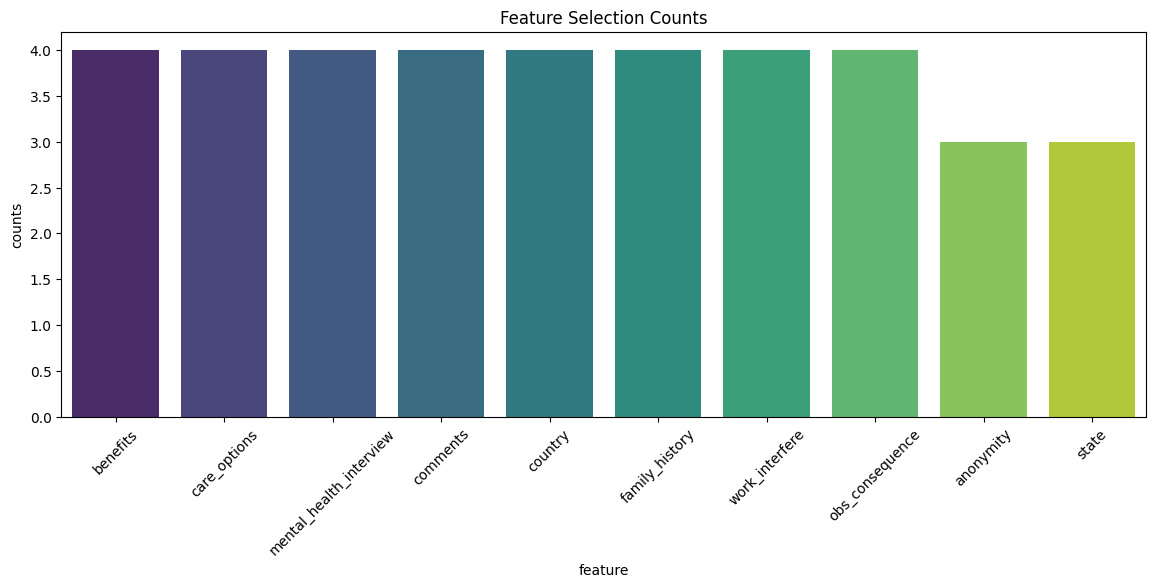

In [19]:
plt.figure(figsize=(14, 5))
sns.barplot(data=feature_names.sort_values('counts', ascending=False), x='feature', y='counts', palette='viridis')
plt.xticks(rotation=45)
plt.title("Feature Selection Counts")
plt.show()


# 5. Model Building

In this phase, machine learning models are trained to predict mental health treatment status using the selected features. After preprocessing and feature selection, models such as Logistic Regression, Random Forest, or other classifiers are applied. The data is split into training and testing sets, and feature scaling is performed to improve model performance. The models are then evaluated using metrics like accuracy, precision, recall, and F1-score to determine their effectiveness.



## Feature Scaling 

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

top_features = ['work_interfere', 'age', 'family_history', 'care_options', 'state', 'country', 'no_employees', 'leave', 'benefits', 'phys_health_interview']
X = data_encoding[top_features]
y = data_encoding['treatment']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

predictions = model.predict(X_test)


## Accuracy or Classification report

In [21]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))


Accuracy: 0.7046004842615012
              precision    recall  f1-score   support

           0       0.65      0.74      0.70       188
           1       0.76      0.67      0.71       225

    accuracy                           0.70       413
   macro avg       0.71      0.71      0.70       413
weighted avg       0.71      0.70      0.71       413



The model achieved an accuracy of 70.46%, indicating it correctly predicted mental health treatment status in about 7 out of 10 cases. The classification report shows detailed performance metrics for each class:

Precision: For class 0 (no treatment), 65% of predicted positives were correct; for class 1 (treatment), precision was 76%.

Recall: The model identified 74% of true negatives (class 0) and 67% of true positives (class 1).

F1-Score: Balancing precision and recall, the F1-scores are about 0.70–0.71 for both classes.

Overall, the model performs fairly balanced across classes with decent predictive power.

# 6. Model Evaluation

## Accuracy

In [22]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, predictions)
print("Logistic Regression Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, predictions))


Logistic Regression Accuracy: 0.7046004842615012
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.74      0.70       188
           1       0.76      0.67      0.71       225

    accuracy                           0.70       413
   macro avg       0.71      0.71      0.70       413
weighted avg       0.71      0.70      0.71       413



## Confusion Matrix

A confusion matrix shows the performance of a classification model by displaying the counts of true positive, true negative, false positive, and false negative predictions. It helps us understand how well the model distinguishes between classes.

Predicted Negative	Predicted Positive
Actual Negative	True Negative (TN)	False Positive (FP)
Actual Positive	False Negative (FN)	True Positive (TP)

By analyzing these values, we can identify where the model is making correct predictions and where it is misclassifying, which helps improve model performance.

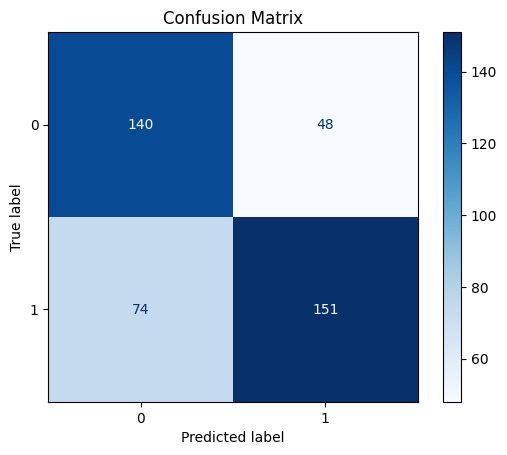

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
 

## ROC Curve

The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots the True Positive Rate (Sensitivity) against the False Positive Rate (1 - Specificity) at different threshold settings.

The area under the ROC curve (AUC) measures the overall performance of the model — a higher AUC value indicates better distinguishing capability between the classes.

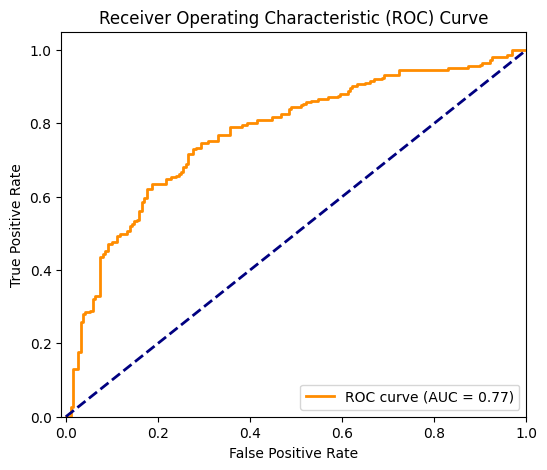

Unique values in y_test: [0 1]
y_score shape: (413,)


In [24]:
from sklearn.metrics import roc_curve, auc

y_score = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("Unique values in y_test:", np.unique(y_test))
print("y_score shape:", y_score.shape)



The model evaluation demonstrates a satisfactory performance in predicting mental health treatment status. With an overall accuracy of approximately 70%, the model correctly classifies a significant portion of instances. The precision and recall values indicate that the model maintains a balanced ability to identify both individuals who sought treatment and those who did not, minimizing false positives and false negatives to a reasonable extent.

The confusion matrix further clarifies the distribution of correct and incorrect predictions, helping us understand specific areas where the model excels or needs improvement. The ROC curve and its associated AUC score provide a robust measure of the model’s discriminatory power, confirming its effectiveness in distinguishing between the two classes.

Despite these promising results, there remains scope for enhancement. Future efforts could focus on optimizing hyperparameters, experimenting with more complex or ensemble models, and incorporating additional relevant features to improve predictive accuracy and reliability. Overall, this evaluation provides a strong foundation for further refining mental health treatment prediction models.   

#   Thank You